## import packages

In [2]:
import glob
import pandas as pd
from nilearn import image, plotting, masking
import numpy as np
%matplotlib inline

## define some paths

In [3]:
baseDir = '/dartfs-hpc/rc/lab/W/WheatleyT/f00589z/hyperscanning/'
dataDir_1 = baseDir + 'storytelling/nuisRegr_input_files/'
epiExample = glob.glob(dataDir_1 + '*MNI152NLin2009cAsym_preproc.nii.gz', recursive=True)[0]
parcDir = baseDir + 'preprocessing/parcellations/'
hcpPath = parcDir + 'MMP_in_MNI_corr.nii.gz'
hoPath = '/dartfs-hpc/rc/home/z/f00589z/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_atlas-HOSPA_desc-th50_dseg.nii.gz'
cerPath = parcDir + 'atl-Anatom_space-MNI_dseg.nii'
wholeBrainMask = baseDir + 'misc/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_mask_RESAMPLED_minus_911_ventral_cerebellum_vox.nii' # updated September, 2021

## load the Human Connectom Project (hcp), Harvard Oxford subcortical (ho), and Diedrichsen cerebellum (cer) atlases and an example EPI file with nilearn and print some info

In [4]:
def print_img_info(path,label):

    img = image.load_img(path)
    print(f'\n{label} affine:')
    print(img.affine)
    print(f'{label} shape: {img.shape[:3]}')
    print(f'# unique values: {len(np.unique(img.dataobj))}')

    return img

hcp = print_img_info(hcpPath,'hcp')
ho = print_img_info(hoPath,'ho')
cer = print_img_info(cerPath,'cer')
epi = print_img_info(epiExample,'epi')



hcp affine:
[[  -1.     0.     0.   127.5]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   146.5]
 [   0.     0.     0.     1. ]]
hcp shape: (256, 256, 256)
# unique values: 361

ho affine:
[[   2.     0.    -0.   -96.5]
 [   0.     2.    -0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]
ho shape: (97, 115, 97)
# unique values: 22

cer affine:
[[   1.    0.    0.  -70.]
 [   0.    1.    0. -100.]
 [   0.    0.    1.  -75.]
 [   0.    0.    0.    1.]]
cer shape: (141, 95, 87)
# unique values: 35

epi affine:
[[   3.    0.    0.  -96.]
 [   0.    3.    0. -132.]
 [   0.    0.    3.  -78.]
 [   0.    0.    0.    1.]]
epi shape: (65, 77, 65)
# unique values: 48611


## resample atlases to the epi image

In [5]:
def resample_atlas_to_epi(atlas,epi,label,interpolation='nearest'):

    atlas_rs = image.resample_img(
        atlas,
        target_affine=epi.affine,
        target_shape=epi.shape[:3],
        interpolation=interpolation
    )

    print(f'\nresampled {label} affine:')
    print(atlas_rs.affine)
    print(f'resampled {label} shape: {atlas_rs.shape[:3]}')
    print(f'number of unique voxels in resampled {label} atlas: {len(np.unique(atlas_rs.dataobj))}')

    return atlas_rs

hcp_rs = resample_atlas_to_epi(hcp,epi,'hcp')
ho_rs = resample_atlas_to_epi(ho,epi,'ho')
cer_rs = resample_atlas_to_epi(cer,epi,'cer')


resampled hcp affine:
[[   3.    0.    0.  -96.]
 [   0.    3.    0. -132.]
 [   0.    0.    3.  -78.]
 [   0.    0.    0.    1.]]
resampled hcp shape: (65, 77, 65)
number of unique voxels in resampled hcp atlas: 361

resampled ho affine:
[[   3.    0.    0.  -96.]
 [   0.    3.    0. -132.]
 [   0.    0.    3.  -78.]
 [   0.    0.    0.    1.]]
resampled ho shape: (65, 77, 65)
number of unique voxels in resampled ho atlas: 22

resampled cer affine:
[[   3.    0.    0.  -96.]
 [   0.    3.    0. -132.]
 [   0.    0.    3.  -78.]
 [   0.    0.    0.    1.]]
resampled cer shape: (65, 77, 65)
number of unique voxels in resampled cer atlas: 34


## visualize resampled atlases

/dartfs-hpc/rc/home/z/f00589z/.conda/envs/hypeScanCentral/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


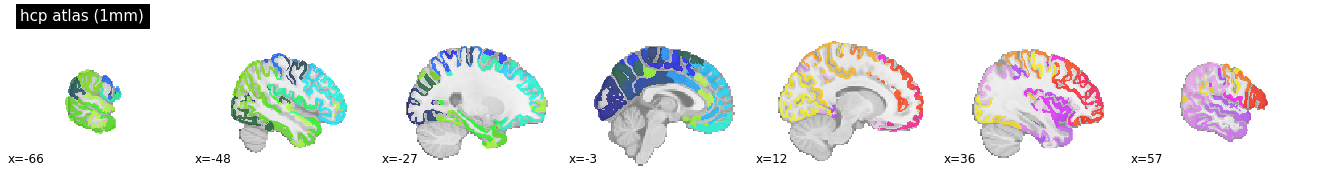

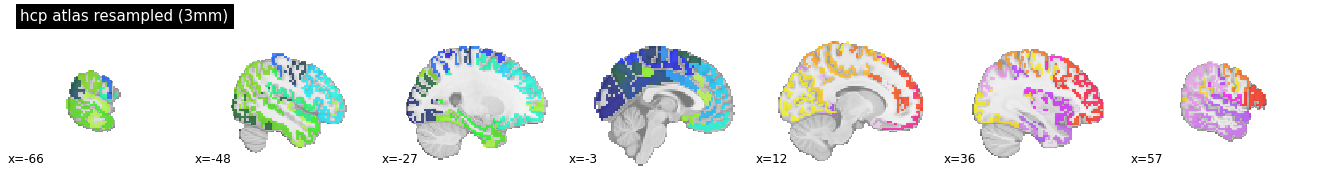

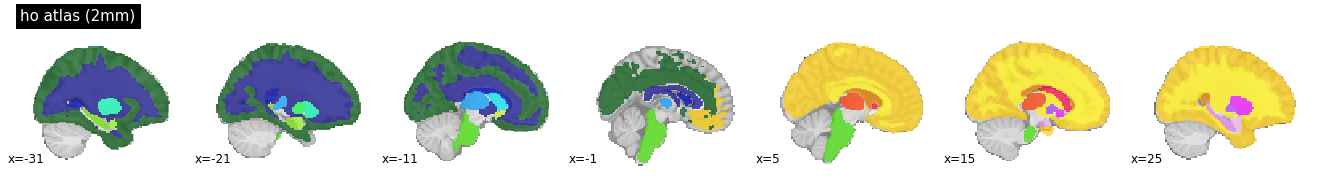

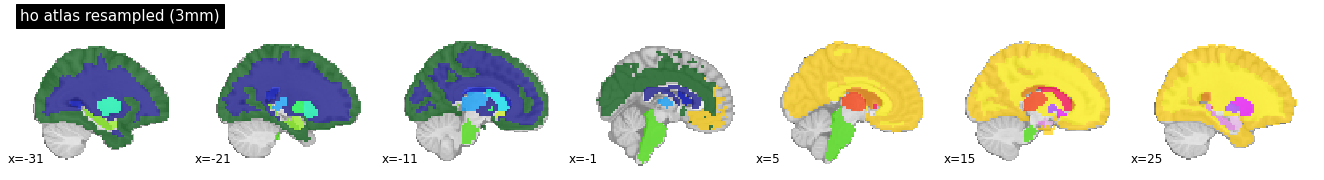

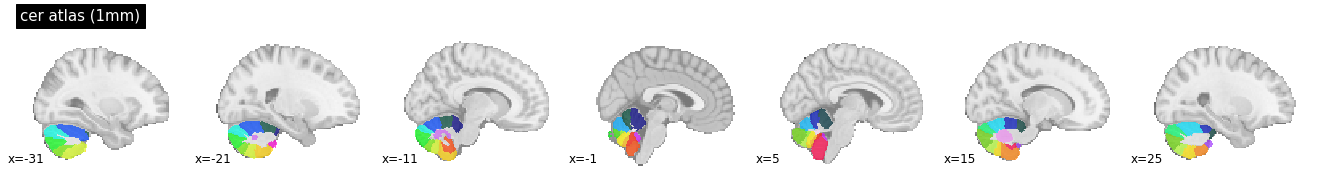

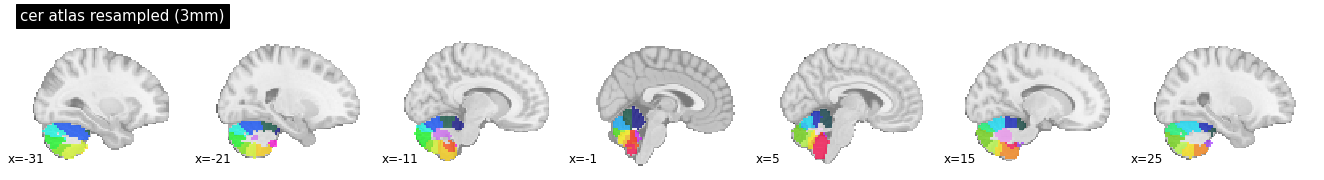

In [6]:
plotting.plot_roi(hcp,display_mode='x',cut_coords=(-66,-48,-27,-3,12,36,57), title='hcp atlas (1mm)')
plotting.plot_roi(hcp_rs,display_mode='x',cut_coords=(-66,-48,-27,-3,12,36,57), title='hcp atlas resampled (3mm)')
plotting.plot_roi(ho,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25), title='ho atlas (2mm)')
plotting.plot_roi(ho_rs,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25), title='ho atlas resampled (3mm)')
plotting.plot_roi(cer,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25), title='cer atlas (1mm)')
plotting.plot_roi(cer_rs,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25), title='cer atlas resampled (3mm)')

## remove cortical, white matter, and ventricular ROIs from the ho atlas

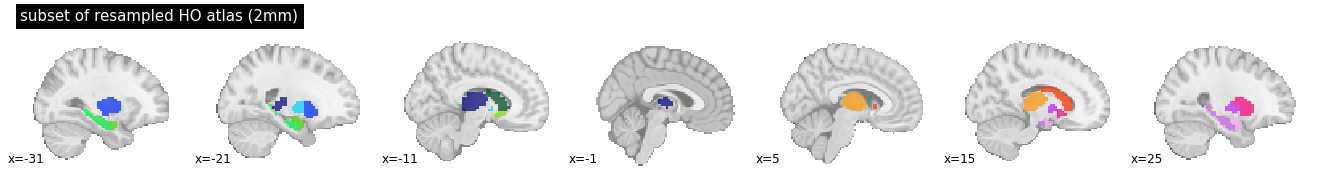

In [7]:
# Define ROI key for the ho atlas. NOte that this was keu was created manually by cross referencing the tsv file for the MNI152NLin6Asym ho atlas that came with tensorflow (tpl-MNI152NLin6Asym_atlas-HOSPA_dseg.tsv) -- an equivalent .tsv for the MNI152NLin2009cAsym parcellation didn't come with tensorflow -- and plotting individual ROIs on the brain to confirm.

hoROIs = ['Left Cerebral White Matter',
          'Left Cerebral Cortex',
          'Left Lateral Ventrical',
          'Left Thalamus',
          'Left Caudate',
          'Left Putamen',
          'Left Pallidum',
          'Brainstem',
          'Left Hippocampus',
          'Left Amygdala',
          'Left Accumbens',
          'Right Cerebral White Matter',
          'Right Cerebral Cortex',
          'Right Lateral Ventricle',
          'Right Thalamus',
          'Right Caudate',
          'Right Putamen',
          'Right Pallidum',
          'Right Hippocampus',
          'Right Amygdala',
          'Right Accumbens']
hoInds = np.arange(1,22)
hoKey = pd.DataFrame({'value':hoInds,'ROI':hoROIs})

# select ROIs to remove
rois2Remove = ['Left Cerebral White Matter',
               'Left Cerebral Cortex',
               'Left Lateral Ventrical',
               'Brainstem',
               'Right Cerebral White Matter',
               'Right Cerebral Cortex',
               'Right Lateral Ventricle']

# get resampled ho atlas data as a numpy array
hoData = image.get_data(ho_rs).astype(np.uint16)

# for each ROI to be removed...
removalInds = []
for ROI in rois2Remove:

    toRemove = int(hoKey['value'][hoKey['ROI'] == ROI]) # get corresponding atlas value
    hoData[hoData == toRemove] = 0 # zero that value
    removalInds.append(hoKey[hoKey['ROI'] == ROI].index[0])

# get a new subset image and plot
ho_rs_subset = image.new_img_like(ho_rs,hoData)
plotting.plot_roi(ho_rs_subset,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25), title='subset of resampled HO atlas (2mm)')

# reconfigure a subsetted version of hoKey
hoKey_sub = hoKey.copy()
hoKey_sub = hoKey_sub.drop(removalInds).reset_index(drop=True)
hoKey_sub['value'] = np.arange(hoKey_sub.shape[0]) + 401

## remove the region of the ventral cerebellum that was truncated in some of our DHMC subjects from the cer atlas

657 voxels removed


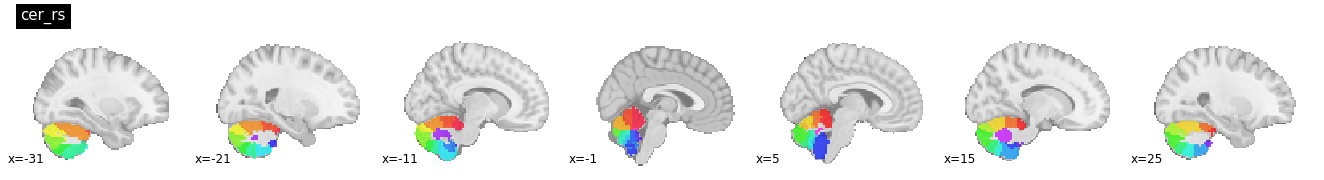

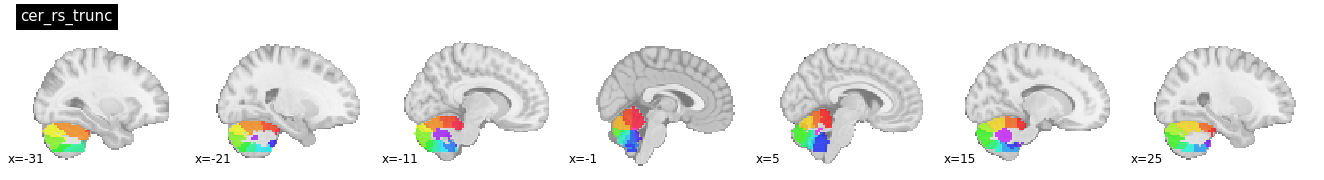

In [8]:
# get the truncated mask that we use for whole brain analyses
wholeBrainImg = image.load_img(wholeBrainMask)

# get binary image of cerebellum atlas
cerData = image.get_data(cer_rs).astype(np.uint16) # get cerebellum atlas as a numpy array
cerData[cerData > 0] = cerData[cerData > 0] + 500 # reset cer ROI values to consecutive integers from 501
cerData_bin = np.copy(cerData) # make a copy
cerData_bin[cerData_bin > 0] = 1 # binarize the array
cerData_bin_img = image.new_img_like(cer_rs,cerData_bin) # generate binary image

# intersect masks and only keep the intersection
cer_rs_trunc_bin = masking.intersect_masks([cerData_bin_img, wholeBrainImg], threshold=1)

# get the intersected image as a numpy array, repopulate it with the ROI values, then convert back to image
cerData_trunc = image.get_data(cer_rs_trunc_bin).astype(np.uint16)
cerData_trunc[cerData_trunc > 0] = cerData[cerData_trunc > 0]
cer_rs_trunc = image.new_img_like(cer_rs,cerData_trunc)

# print the number of voxels removed as a result of truncating the atlas
print(f'{len(np.where(cerData > 0)[0]) - len(np.where(cerData_trunc > 0)[0])} voxels removed')

# plot non-truncated vs truncated atlases
plotting.plot_roi(cer_rs,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25),title='cer_rs',cmap='gist_rainbow')
plotting.plot_roi(cer_rs_trunc,display_mode='x',cut_coords=(-31,-21,-11,-1,5,15,25),title='cer_rs_trunc',cmap='gist_rainbow')

## log ROIs that lost voxels after truncating the cerebellum atlas

In [9]:
# load and reformat the cerebellum atlas key
cerKey = pd.read_csv(parcDir + 'cerebellum_parcellation.csv') # load cerebellum atlas key
cerKey = cerKey.drop(['color'],axis=1) # drop the color column
cerKey['value'] = cerKey['value'] + 500 # set cerebellum ROIs to start at 501

# get number of voxels in truncated and non-truncated atlas ROIs
nVox = [] # initialize list to count voxels in non-truncated atlas
nVox_trunc = [] # initialize list to count voxels in truncated atlas
for VAL in cerKey['value']: # for each ROI...
    nVox.append(len(np.where(cerData == VAL)[0])) # append number of voxels in non-truncated atlas ROI to nVox
    nVox_trunc.append(len(np.where(cerData_trunc == VAL)[0])) # append number of voxels in truncated atlas ROI to nVox_trunc

# modify the cerebellum atlas key into a table to track ROIs that lost voxels after truncating
truncLoss = cerKey.copy() # copy the atlas key
truncLoss['nVox_non_truncated'] = nVox # add the number of voxels in the non-truncated atlas
truncLoss['nVox_truncated'] = nVox_trunc # add the number of voxels in the truncated atlas
truncLoss['difference'] = truncLoss['nVox_non_truncated'] - truncLoss['nVox_truncated'] # add the difference
truncLoss = truncLoss.loc[truncLoss['difference'] > 0] # drop rows where there was no difference
print(truncLoss.to_string()) # print the table
truncLoss.to_csv(parcDir + 'cerebellar_voxels_lost_by_ROI_after_truncation.csv',index=False) # save the table as a csv

    value           ROI  nVox_non_truncated  nVox_truncated  difference
6     507      Right_VI                 410             408           2
7     508    Left_CrusI                 665             662           3
9     510   Right_CrusI                 629             623           6
10    511   Left_CrusII                 496             486          10
12    513  Right_CrusII                 474             472           2
13    514     Left_VIIb                 258             190          68
15    516    Right_VIIb                 274             185          89
16    517    Left_VIIIa                 253             158          95
18    519   Right_VIIIa                 241             149          92
19    520    Left_VIIIb                 204             103         101
21    522   Right_VIIIb                 211             105         106
22    523       Left_IX                 160             128          32
24    525      Right_IX                 180             139     

## combine the three atlas keys into a master key

In [10]:
# load the Glasser key (originally downloaded from here: https://bitbucket.org/dpat/tools/src/master/REF/ATLASES/Glasser_2016_Table.xlsx)
glasserKey = pd.read_csv(parcDir + 'Glasser_2016_Table.csv')

# reconfigure the Glasser key
hcpKeyL = glasserKey.iloc[1:,[0,2]].reset_index(drop=True)  # make a new dataFrame with only the value and ROI description columns (this will contain the Left ROIs)
hcpKeyL.columns = ['value','ROI'] # rename the columns
hcpKeyL['value'] = [int(i) for i in hcpKeyL['value']] # convert the values to integers
hcpKeyR = hcpKeyL.copy() # make a copy (this will contain the Right ROIs)
hcpKeyR['value'] = np.array(hcpKeyR['value']) + 200 # assign the right ROIs their proper values from 201 to 380
hcpKeyL['ROI'] = ['L ' + i for i in hcpKeyL['ROI']] # add an 'L' to the left ROI names
hcpKeyR['ROI'] = ['R ' + i for i in hcpKeyR['ROI']] # add an 'R' to the right ROI names
hcpKey = pd.concat([hcpKeyL,hcpKeyR],axis=0).reset_index(drop=True) # combine the left and right keys

# combine with ho key
masterKey = pd.concat([hcpKey,hoKey_sub]).reset_index(drop=True)

# add cerebellum key to master key
masterKey = pd.concat([masterKey,cerKey]).reset_index(drop=True)
print(masterKey.to_string())

     value                                          ROI
0        1                      L Primary Visual Cortex
1        2             L Medial Superior\nTemporal Area
2        3                          L Sixth Visual Area
3        4                         L Second Visual Area
4        5                          L Third Visual Area
5        6                         L Fourth Visual Area
6        7                         L Eighth Visual Area
7        8                      L Primary Motor\nCortex
8        9                    L Primary Sensory\nCortex
9       10                         L Frontal Eye Fields
10      11                         L Premotor Eye Field
11      12                                   L Area 55b
12      13                                   L Area V3A
13      14                      L RetroSplenial Complex
14      15            L Parieto-Occipital Sulcus Area 2
15      16                        L Seventh Visual Area
16      17                L IntraParietal Sulcus

## find overlapping voxels between the hcp and ho atlases

In [11]:
# get atlas data
hcpData = image.get_data(hcp_rs).astype(np.uint16) # get hcp data as a numpy array
hcpData_bin = np.copy(hcpData) # make a copy to use for binarizing
hoRSdata = image.get_data(ho_rs_subset).astype(np.uint16) # get ho data as a numpy array

# reset ho ROI values to consecutive integers from 401
newROIval = 401 # start at 401
for ROI in np.unique(hoRSdata)[1:]: # for each ho ROI...
    hoRSdata[hoRSdata == ROI] = newROIval # reset the ROI value
    newROIval += 1 # increment the new ROI value

# binarize
hoRSdata_bin = np.copy(hoRSdata) # make a copy to use for binarizing
hcpData_bin[hcpData > 0] = 1 # binarize the hcp atlas (1=any ROI, 0=anything outside the atlas)
hoRSdata_bin[hoRSdata > 0] = 1 # binarize the ho atlas (1=any ROI, 0=anything outside the atlas)

# find overlap between atlases
binSum = hcpData_bin + hoRSdata_bin # sum the binarized atlases
overlapInds = np.array(np.where(binSum == 2)) # get indices of overlap (wherever there's a sum of 2)
nOinds = len(overlapInds[0]) # get number of voxels that overlap between atlases
print(f'overlap between hcp and ho atlases found at {nOinds} voxels') # feedback
coverage = len(np.where(binSum > 0)[0]) # get total number of voxels covered between atlases
print(f'total coverage between atlases: {coverage} voxels')
hcpOval = [[]] * nOinds # initialize list of overlapping values in the hcp atlas
hcpOroi = [[]] * nOinds # initialize list of overlapping ROIs in the hcp atlas
hoOval = [[]] * nOinds # initialize list of overlapping values in the ho atlas
hoOroi = [[]] * nOinds # initialize list of overlapping ROIs in the ho atlas
xyz = [[]] * nOinds # initialize list of voxel coordinates
hcpROIsize = [[]] * nOinds # initialize list of hcp ROI sizes
hoROIsize = [[]] * nOinds # initialize list of hcp ROI sizes
for OIND in range(overlapInds.shape[1]): # for each overlapping voxel index...
    hcpOval[OIND] = hcpData[overlapInds[0,OIND],overlapInds[1,OIND],overlapInds[2,OIND]] # get the hcp value
    hcpOroi[OIND] = masterKey['ROI'][masterKey['value'] == hcpOval[OIND]].to_list()[0]
    hoOval[OIND] = hoRSdata[overlapInds[0,OIND],overlapInds[1,OIND],overlapInds[2,OIND]] # get the ho value
    hoOroi[OIND] = masterKey['ROI'][masterKey['value'] == hoOval[OIND]].to_list()[0]
    xyz[OIND] = f'{overlapInds[0,OIND]},{overlapInds[1,OIND]},{overlapInds[2,OIND]}' # get voxel coordinates
    hcpROIsize[OIND] = len(np.where(hcpData == hcpOval[OIND])[0]) # get given hcp ROI size for reference
    hoROIsize[OIND] = len(np.where(hoRSdata == hoOval[OIND])[0]) # get given ho ROI size for reference

# combine overlap info in a datadrame
overlap = pd.DataFrame({'hcp_value':hcpOval,'hcp_ROI':hcpOroi,'hcp_ROI_size':hcpROIsize,'ho_value':hoOval,'ho_ROI':hoOroi,'ho_ROI_size':hoROIsize,'xyz':xyz})

# feedback about which ho ROIs are showing overlap
print('\nROIs in the ho atlas that have overlap with the hcp atlas:')
hcp_overlap_rois = overlap['hcp_ROI'].unique()
for ROI in hcp_overlap_rois:
    print(ROI)

# feedback about which hcp ROIs are showing overlap
print('\nROIs in the hcp atlas that have overlap with the hcp atlas:')
ho_overlap_rois = overlap['ho_ROI'].unique()
for ROI in ho_overlap_rois:
    print(ROI)

# print overlap table
print(f'\n{overlap.to_string()}')

overlap between hcp and ho atlases found at 150 voxels
total coverage between atlases: 25406 voxels

ROIs in the ho atlas that have overlap with the hcp atlas:
L Hippocampus
L Pirform Cortex
L Perirhinal Ectorhinal Cortex
L PreSubiculum
L Entorhinal Cortex
R Hippocampus
R Entorhinal Cortex
R PreSubiculum

ROIs in the hcp atlas that have overlap with the hcp atlas:
Left Hippocampus
Left Amygdala
Right Hippocampus
Right Amygdala

     hcp_value                         hcp_ROI  hcp_ROI_size  ho_value             ho_ROI  ho_ROI_size       xyz
0          120                   L Hippocampus            48       405   Left Hippocampus          166  21,32,24
1          120                   L Hippocampus            48       405   Left Hippocampus          166  21,34,22
2          120                   L Hippocampus            48       405   Left Hippocampus          166  21,35,21
3          120                   L Hippocampus            48       405   Left Hippocampus          166  21,37,20
4  

## assign overlapping hcp/ho voxels to one of the two atlases

In [12]:
# Rules
# For the ho atlas, overlap only occurs with the hippocampus and amygdala ROIs. So we break down the rules by these two regions. Importantly, while the hcp atlas does not have an amygdala ROI, it DOES have hippocampus ROIs.
# (1) For ho hippocampus voxels
#   (1a) If the hcp ROI containing the overlapping voxel is also "Hippocampus", then assign this voxel to the ho ROI.
#   (1b) If the hcp ROI containing the overlapping voxel is NOT "Hippocampus", then assign this voxel to the hcp ROI -- this is because the hcp parcellation has hippocampal subcomponents, which we preserve here.
# (2) For ho amygdala voxels, assign the ho amygdala voxel to the hcp ROI
# (3) Reassign unique hpc hippocampus voxels to the ho hippocampus ROI
#
# The upshot is that we remove the hpc hippocampus ROIs. So in the end we are using 358 hpc ROIs and 14 ho ROIs.

hcpData_o = np.copy(hcpData)
hoData_o = np.copy(hoRSdata)
print(f'# voxels in HCP atlas: {len(np.where(hcpData_o > 0)[0])}')
print(f'# voxels in HO atlas: {len(np.where(hoData_o > 0)[0])}')

for HCP in hcp_overlap_rois: # for each overlapping HCP ROI...
    for HO in ho_overlap_rois: # for each overlapping HO ROI...

        # get temporary dataframe with just the overlap in the current ROIs
        tmp = overlap.loc[(overlap["hcp_ROI"] == HCP) & (overlap["ho_ROI"] == HO)].reset_index(drop=True)

        # if there are overlapping voxels between the current ROIs
        if tmp.shape[0] > 0:

            hcpSize = overlap["hcp_ROI_size"][np.where(overlap["hcp_ROI"] == HCP)[0][0]]
            hoSize = overlap["ho_ROI_size"][np.where(overlap["ho_ROI"] == HO)[0][0]]

            print(f'\nnumber of overlapping voxels between HCP {HCP} and HO {HO}: {tmp.shape[0]}')
            print(f'HCP {HCP} size: {hcpSize} voxels')
            print(f'HO {HO} size: {hoSize} voxels')
            print(f'proportion of HCP {HCP} overlapping HO {HO}: {np.round(tmp.shape[0]/hcpSize,2)}')
            print(f'proportion of HO {HO} that overlaps with HCP {HCP}: {np.round(tmp.shape[0]/hoSize,2)}')

            # for each overlapping hippocampus voxel...
            for ROW in range(tmp.shape[0]):

                # get voxels coordinates
                coords = [int(i) for i in list(tmp["xyz"][ROW].split(","))]

                # if we're dealing with overlapping hippocampus ROIs...
                if 'Hippocampus' in HCP and 'Hippocampus' in HO:

                    # replace the HCP value with a zero (rule 1a)
                    hcpData_o[coords[0],coords[1],coords[2]] = 0

                else:

                    # replace the HO value with a zero (rules 1b,2)
                    hoData_o[coords[0],coords[1],coords[2]] = 0

# reassign unique HCP hippocamus voxels to the HO ROI
hcpData_o[hcpData_o == 120] = overlap['ho_value'][np.where(overlap['ho_ROI'] == 'Left Hippocampus')[0][0]] # left
hcpData_o[hcpData_o == 320] = overlap['ho_value'][np.where(overlap['ho_ROI'] == 'Right Hippocampus')[0][0]] # right

# voxels in HCP atlas: 23269
# voxels in HO atlas: 2287

number of overlapping voxels between HCP L Hippocampus and HO Left Hippocampus: 34
HCP L Hippocampus size: 48 voxels
HO Left Hippocampus size: 166 voxels
proportion of HCP L Hippocampus overlapping HO Left Hippocampus: 0.71
proportion of HO Left Hippocampus that overlaps with HCP L Hippocampus: 0.2

number of overlapping voxels between HCP L Pirform Cortex and HO Left Amygdala: 2
HCP L Pirform Cortex size: 31 voxels
HO Left Amygdala size: 82 voxels
proportion of HCP L Pirform Cortex overlapping HO Left Amygdala: 0.06
proportion of HO Left Amygdala that overlaps with HCP L Pirform Cortex: 0.02

number of overlapping voxels between HCP L Perirhinal Ectorhinal Cortex and HO Left Amygdala: 9
HCP L Perirhinal Ectorhinal Cortex size: 127 voxels
HO Left Amygdala size: 82 voxels
proportion of HCP L Perirhinal Ectorhinal Cortex overlapping HO Left Amygdala: 0.07
proportion of HO Left Amygdala that overlaps with HCP L Perirhinal Ectorhinal

## double check that overlap is gone and we have the same coverage, then combine the atlases in a numpy array

In [13]:
# binarize and sum again
hcpData_o_bin = np.copy(hcpData_o)
hoData_o_bin = np.copy(hoData_o)
hcpData_o_bin[hcpData_o_bin > 0] = 1
hoData_o_bin[hoData_o_bin > 0] = 1
binSum_por = hcpData_o_bin + hoData_o_bin # binary sum post-overlap removal
print(f'\n# of overlapping voxels after attempting to remove overlap: {len(np.where((binSum_por) == 2)[0])}')
coverage_por = len(np.where(binSum_por > 0)[0]) # get coverage post-overlap removal
print(f'total coverage between modified atlases: {coverage_por} voxels')
if coverage_por == coverage:
    print('Yay. Overlap successfully removed.')
else:
    print('Something is not right! Investigate.')

# remove the hippocampus rows from the master key accordingly
masterKey = masterKey.drop(masterKey[(masterKey['ROI'] == 'L Hippocampus') | (masterKey['ROI'] == 'R Hippocampus')].index).reset_index(drop=True)

# combine the now non-overlapping atlases in a numpy array
hcphoData = hcpData_o + hoData_o


# of overlapping voxels after attempting to remove overlap: 0
total coverage between modified atlases: 25406 voxels
Yay. Overlap successfully removed.


## check for overlap between combined hcp/ho and cer atlases

In [14]:
# binarize
hcphoData_bin = np.copy(hcphoData) # make a copy to use for binarizing
cerData_trunc_bin = np.copy(cerData_trunc) # make a copy to use for binarizing
hcphoData_bin[hcphoData > 0] = 1 # binarize the combined hcp/ho atlas (1=any ROI, 0=anything outside the atlas)
cerData_trunc_bin[cerData_trunc > 0] = 1 # binarize the cer atlas (1=any ROI, 0=anything outside the atlas)

# check for overlap between atlases
binSum_comb_cer = hcphoData_bin + cerData_trunc_bin # sum the binarized atlases
overlapInds_comb_cer = np.array(np.where(binSum_comb_cer == 2)) # get indices of overlap (wherever there's a sum of 2)
nOinds = len(overlapInds_comb_cer[0]) # get number of voxels that overlap between atlases
print(f'overlap between combined hcp/ho and cer atlases found at {nOinds} voxels') # feedback
if nOinds == 0:
    print('No overlap. Yay.')
coverage = len(np.where(binSum_comb_cer > 0)[0]) # get total number of voxels covered between atlases
print(f'total coverage between atlases: {coverage} voxels')


overlap between combined hcp/ho and cer atlases found at 0 voxels
No overlap. Yay.
total coverage between atlases: 30926 voxels


## combine hcp/ho and cer atlases and add # voxels per ROI to master key

In [16]:
# combine hcp/ho and cer atlases in numpy array
masterData = hcphoData + cerData_trunc

nVox = [] # initialize list for voxel counts
for VAL in masterKey['value']: # for each ROI...
    nVox_tmp = len(np.where(masterData == VAL)[0])
    if nVox_tmp == 0:
        print(f'dropping {masterKey["ROI"][masterKey.loc[masterKey["value"] == VAL].index[0]]} from the master key as it has no voxels after resampling')
        masterKey = masterKey.drop(masterKey.loc[masterKey["value"] == VAL].index).reset_index(drop=True) # remove any ROIs that got eliminated when we resampled to a lower resolution
    else:
        nVox.append(nVox_tmp) # append number of voxels to nVox
masterKey['nVox'] = nVox # add nVox to the master key dataframe
print(f'\n{masterKey.to_string()}') # print key


     value                                          ROI  nVox
0        1                      L Primary Visual Cortex   237
1        2             L Medial Superior\nTemporal Area    11
2        3                          L Sixth Visual Area    36
3        4                         L Second Visual Area   222
4        5                          L Third Visual Area   184
5        6                         L Fourth Visual Area   122
6        7                         L Eighth Visual Area    41
7        8                      L Primary Motor\nCortex   240
8        9                    L Primary Sensory\nCortex    83
9       10                         L Frontal Eye Fields    28
10      11                         L Premotor Eye Field    28
11      12                                   L Area 55b    63
12      13                                   L Area V3A    43
13      14                      L RetroSplenial Complex    31
14      15            L Parieto-Occipital Sulcus Area 2    91
15     

## intersect the master atlas with the whole brain mask, log voxel loss in hpc and ho ROIs, and modify master atlas and key accordingly

In [19]:
# get binary image of master atlas
masterData_bin = np.copy(masterData) # make a copy of the master atlas numpy array
masterData_bin[masterData_bin > 0] = 1 # binarize the array
masterData_bin_bin_img = image.new_img_like(cer_rs,masterData_bin) # generate binary image

# intersect masks and only keep the intersection
master_trunc_bin = masking.intersect_masks([masterData_bin_bin_img, wholeBrainImg], threshold=1)

# get the intersected image as a numpy array, repopulate it with the ROI values, then convert back to image
masterData_trunc = image.get_data(master_trunc_bin).astype(np.uint16)
masterData_trunc[masterData_trunc > 0] = masterData[masterData_trunc > 0]
# master_trunc_img = image.new_img_like(cer_rs,masterData_trunc)

# print the number of voxels removed as a result of truncating the atlas
print(f'{len(np.where(masterData > 0)[0]) - len(np.where(masterData_trunc > 0)[0])} voxels removed')

# get number of voxels in newly intersected atlas
nVox_trunc = [] # initialize list to count voxels in truncated atlas
for VAL in masterKey['value']: # for each ROI...
    nVox_trunc.append(len(np.where(masterData_trunc == VAL)[0])) # append number of voxels in truncated atlas ROI to nVox_trunc

# summarize voxel loss in hpc and ho ROIs after intersection with whole brain mask in table
masterKey['nVox_truncated'] = nVox_trunc # add the number of voxels in the truncated atlas
masterKey['difference'] = masterKey['nVox'] - masterKey['nVox_truncated'] # add the difference
truncLoss_hpc_ho = masterKey.loc[masterKey['difference'] > 0] # drop rows where there was no difference
print(truncLoss_hpc_ho.to_string()) # print the table
print(truncLoss_hpc_ho['difference'].sum())

# concatenate this table with the corresponding table for the cerebellum atlas
truncLoss = truncLoss.rename(columns={"nVox_non_truncated": "nVox"}) # rename column for concatenating
voxels_lost_to_whole_brain_mask = pd.concat([truncLoss_hpc_ho,truncLoss],axis=0).reset_index(drop=True) # concatenate
voxels_lost_to_whole_brain_mask.to_csv(parcDir + 'voxels_lost_to_whole_brain_mask.csv',index=False) # save the table as a csv
print(voxels_lost_to_whole_brain_mask.to_string())

# clean up and save out the master key
masterKey = masterKey.drop(['nVox','difference'],axis=1)
masterKey = masterKey.rename(columns={"nVox_truncated": "nVox"})
masterKey.to_csv(parcDir + 'master_atlas_key.csv',index=False)
print(masterKey.to_string())

250 voxels removed
     value                                          ROI  nVox  nVox_truncated  difference
0        1                      L Primary Visual Cortex   237             220          17
3        4                         L Second Visual Area   222             220           2
4        5                          L Third Visual Area   184             183           1
5        6                         L Fourth Visual Area   122             121           1
7        8                      L Primary Motor\nCortex   240             238           2
8        9                    L Primary Sensory\nCortex    83              61          22
15      16                        L Seventh Visual Area    25              19           6
16      17                L IntraParietal Sulcus Area 1    39              36           3
32      33                        L Area ventral 23 a+b    30              29           1
35      36                                    L Area 5m    36              35    

## plot and save master atlas and print some final summary info

/dartfs-hpc/rc/home/z/f00589z/.conda/envs/hypeScanCentral/lib/python3.9/site-packages/numpy/ma/core.py:2825: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


MASTER ATLAS UNLOCKED!!!
cortex: 358 ROIs spanning 22932 voxels
subcortex: 14 ROIs spanning 2224 voxels
cerebellum: 33 ROIs spanning 5520 voxels
total: 405 ROIs spanning 30676 voxels


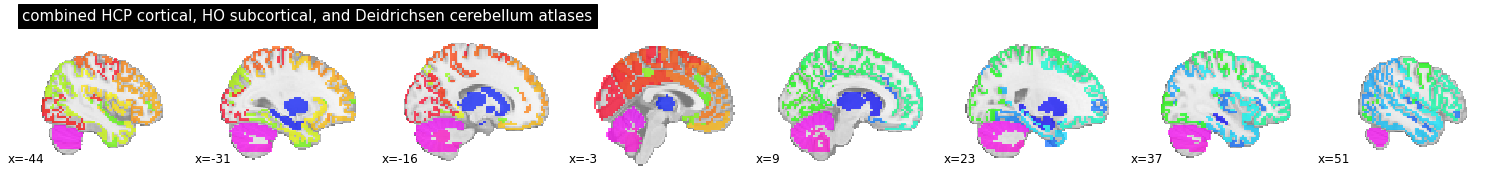

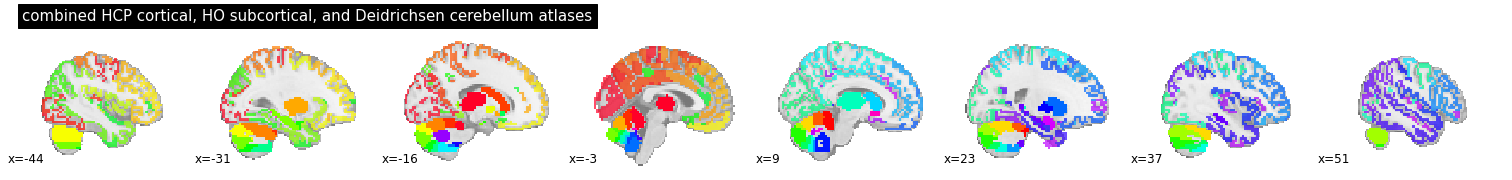

In [27]:
# get combined atlas intersected with whole brain mask as nifti and plot it
masterAtlas = image.new_img_like(hcp_rs,masterData_trunc)
plotting.plot_roi(masterAtlas,display_mode='x',cut_coords=(-44,-31,-16,-3,9,23,37,51), title='combined HCP cortical, HO subcortical, and Deidrichsen cerebellum atlases', cmap='gist_rainbow')

# for more color contrast within cerebellum and subcortical ROIs:
hcpComb = image.new_img_like(hcp_rs,hcpData_o)
hoComb = image.new_img_like(hcp_rs,hoData_o)
display = plotting.plot_roi(hcpComb,display_mode='x',cut_coords=(-44,-31,-16,-3,9,23,37,51),title='combined HCP cortical, HO subcortical, and Deidrichsen cerebellum atlases',cmap='gist_rainbow')
display.add_overlay(hoComb,cmap='gist_rainbow')
display.add_overlay(cer_rs_trunc,cmap='gist_rainbow')

# save out the master atlas
masterAtlas.to_filename(parcDir + 'master_atlas.nii.gz')

# print summary info
hpcRows = masterKey['value'] < 400
hoRows = (masterKey['value'] > 400) & (masterKey['value'] < 500)
cerRows = masterKey['value'] > 500
print(f'MASTER ATLAS UNLOCKED!!!')
print(f'cortex: {len(np.where(hpcRows)[0])} ROIs spanning {masterKey.loc[hpcRows]["nVox"].sum()} voxels')
print(f'subcortex: {len(np.where(hoRows)[0])} ROIs spanning {masterKey.loc[hoRows]["nVox"].sum()} voxels')
print(f'cerebellum: {len(np.where(cerRows)[0])} ROIs spanning {masterKey.loc[cerRows]["nVox"].sum()} voxels')
print(f'total: {masterKey.shape[0]} ROIs spanning {masterKey["nVox"].sum()} voxels')

In [28]:
# write a function to feed in an atlas numerical value and plot the ROI with the ROI name as title
def plotROI(img,key,value,interactive=False):
    mask = image.new_img_like(img, image.get_data(img) == value)
    if interactive:
        view = plotting.view_img(image.new_img_like(img, image.get_data(img) == value),title=key['ROI'][key['value'] == value].to_list()[0])
        return view
    else:
        plotting.plot_roi(mask,title=key['ROI'][key['value'] == value].to_list()[0],cmap='gist_rainbow')

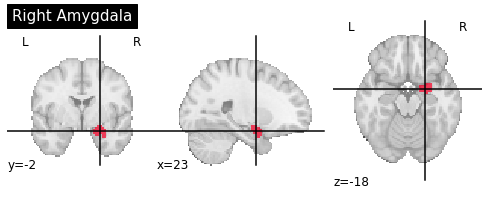

In [29]:
# plot some sanity check ROIs
plotROI(masterAtlas,masterKey,413,interactive=False) # NOTE: right amygdala (413) looks fucked up using zero threshold ho parcellation -- not the case when using the 50% threshold parcellation

In [32]:
!jupyter nbconvert --to html /dartfs-hpc/rc/lab/W/WheatleyT/f00589z/hyperscanning/preprocessing/parcellations/make_master_atlas.ipynb

[NbConvertApp] Converting notebook /dartfs-hpc/rc/lab/W/WheatleyT/f00589z/hyperscanning/preprocessing/parcellations/make_master_atlas.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('execution_count' was unexpected)

Failed validating 'additionalProperties' in markdown_cell:

On instance['cells'][28]:
{'cell_type': 'markdown',
 'execution_count': 1,
 'metadata': {'collapsed': False, 'pycharm': {'name': '#%% md\n'}},
 'source': '## intersect the master atlas with the whole brain mask, log '
           'vox...'}
[NbConvertApp] Writing 1926311 bytes to /dartfs-hpc/rc/lab/W/WheatleyT/f00589z/hyperscanning/preprocessing/parcellations/make_master_atlas.html
